In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2
from os import listdir
from sklearn.preprocessing import LabelBinarizer
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [2]:
EPOCHS = 10
INIT_LR = 1e-3
BS = 32
default_image_size = tuple((256, 256))
image_size = 0
directory_root = "C:/Users/LENOVO/Documents/raw"
width=256
height=256
depth=3

Function to convert images to array

In [3]:
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, default_image_size)   
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

Fetch images from directory

In [4]:
image_list, label_list = [], []
try:
    print("[INFO] Loading images ...")
    root_dir = listdir(directory_root)
    for directory in root_dir :
        # remove .DS_Store from list
        if directory == ".DS_Store" :
            root_dir.remove(directory)

    for plant_folder in root_dir :
        plant_disease_folder_list = listdir(f"{directory_root}/{plant_folder}")
        
        for disease_folder in plant_disease_folder_list :
            # remove .DS_Store from list
            if disease_folder == ".DS_Store" :
                plant_disease_folder_list.remove(disease_folder)

        for plant_disease_folder in plant_disease_folder_list:
            print(f"[INFO] Processing {plant_disease_folder} ...")
            plant_disease_image_list = listdir(f"{directory_root}/{plant_folder}/{plant_disease_folder}/")
                
            for single_plant_disease_image in plant_disease_image_list :
                if single_plant_disease_image == ".DS_Store" :
                    plant_disease_image_list.remove(single_plant_disease_image)

            for image in plant_disease_image_list[:200]:
                image_directory = f"{directory_root}/{plant_folder}/{plant_disease_folder}/{image}"
                if image_directory.endswith(".jpg") == True or image_directory.endswith(".JPG") == True:
                    image_list.append(convert_image_to_array(image_directory))
                    label_list.append(plant_disease_folder)
    print("[INFO] Image loading completed")  
except Exception as e:
    print(f"Error : {e}")

[INFO] Loading images ...
[INFO] Processing Apple___Apple_scab ...
[INFO] Processing Apple___Black_rot ...
[INFO] Processing Apple___Cedar_apple_rust ...
[INFO] Processing Apple___healthy ...
[INFO] Processing Blueberry___healthy ...
[INFO] Processing Orange___Haunglongbing_(Citrus_greening) ...
[INFO] Processing Peach___Bacterial_spot ...
[INFO] Processing Peach___healthy ...
[INFO] Processing Pepper,_bell___Bacterial_spot ...
[INFO] Processing Pepper,_bell___healthy ...
[INFO] Processing Potato___Early_blight ...
[INFO] Image loading completed


Get Size of Processed Image

In [7]:
image_size = len(image_list)

Transform Image Labels uisng [Scikit Learn](http://scikit-learn.org/)'s LabelBinarizer

In [8]:
label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)
pickle.dump(label_binarizer,open('label_transform.pkl', 'wb'))
n_classes = len(label_binarizer.classes_)

Print the classes

In [9]:
print(label_binarizer.classes_)

['Apple___Apple_scab' 'Apple___Black_rot' 'Apple___Cedar_apple_rust'
 'Apple___healthy' 'Blueberry___healthy'
 'Orange___Haunglongbing_(Citrus_greening)' 'Peach___Bacterial_spot'
 'Peach___healthy' 'Pepper,_bell___Bacterial_spot'
 'Pepper,_bell___healthy' 'Potato___Early_blight']


In [13]:
np_image_list = np.array(image_list, dtype=np.float16) / 225.0

In [20]:
print("[INFO] Spliting data to train, test")
x_train, x_test, y_train, y_test = train_test_split(np_image_list, image_labels, test_size=0.2, random_state = 42) 

[INFO] Spliting data to train, test


In [21]:
aug = ImageDataGenerator(
    rotation_range=25, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2, 
    zoom_range=0.2,horizontal_flip=True, 
    fill_mode="nearest")

In [22]:
model = Sequential()
inputShape = (height, width, depth)
chanDim = -1
if K.image_data_format() == "channels_first":
    inputShape = (depth, height, width)
    chanDim = 1
model.add(Conv2D(32, (3, 3), padding="same",input_shape=inputShape))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(1024))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(n_classes))
model.add(Activation("softmax"))

Model Summary

In [23]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 256, 256, 32)      896       
_________________________________________________________________
activation_8 (Activation)    (None, 256, 256, 32)      0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 256, 256, 32)      128       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 85, 85, 32)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 85, 85, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 85, 85, 64)        18496     
_________________________________________________________________
activation_9 (Activation)    (None, 85, 85, 64)       

In [24]:
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
# distribution
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])
# train the network
print("[INFO] training network...")

[INFO] training network...


In [25]:
history = model.fit_generator(
    aug.flow(x_train, y_train, batch_size=BS),
    validation_data=(x_test, y_test),
    steps_per_epoch=len(x_train) // BS,
    epochs=EPOCHS, verbose=1
    )

Epoch 1/10
55/55 [==============================] - 1222s 22s/step - loss: 0.2361 - accuracy: 0.9226 - val_loss: 0.9500 - val_accuracy: 0.8376
Epoch 2/10
55/55 [==============================] - 1205s 22s/step - loss: 0.1666 - accuracy: 0.9425 - val_loss: 1.2478 - val_accuracy: 0.8347
Epoch 3/10
55/55 [==============================] - 1190s 22s/step - loss: 0.1345 - accuracy: 0.9545 - val_loss: 2.2412 - val_accuracy: 0.8376
Epoch 4/10
55/55 [==============================] - 1190s 22s/step - loss: 0.1274 - accuracy: 0.9555 - val_loss: 2.0255 - val_accuracy: 0.8376
Epoch 5/10
55/55 [==============================] - 1324s 24s/step - loss: 0.1076 - accuracy: 0.9632 - val_loss: 2.1325 - val_accuracy: 0.8376
Epoch 6/10
55/55 [==============================] - 1295s 24s/step - loss: 0.1056 - accuracy: 0.9629 - val_loss: 0.9425 - val_accuracy: 0.8552
Epoch 7/10
55/55 [==============================] - 1043s 19s/step - loss: 0.0934 - accuracy: 0.9662 - val_loss: 0.8365 - val_accuracy: 0.8702

Plot the train and val curve

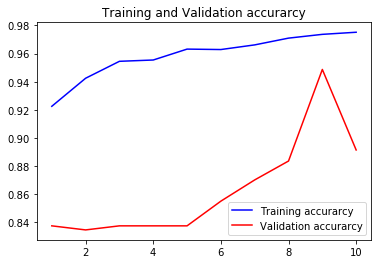

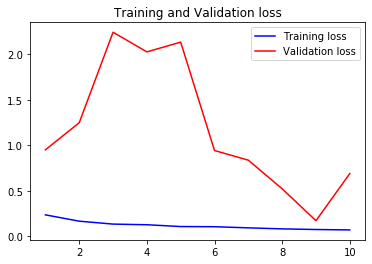

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

Model Accuracy

In [27]:
print("[INFO] Calculating model accuracy")
scores = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {scores[1]*100}")

[INFO] Calculating model accuracy
440/440 [==============================] - 53s 121ms/step
Test Accuracy: 89.15287852287292


Save model using Pickle

In [ ]:
# save the model to disk
print("[INFO] Saving model...")
pickle.dump(model,open('cnn_model.pkl', 'wb'))